In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis = 0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype('float32') / 255

In [3]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [4]:
BATCH_SIZE = 128
LATENT_DIM = 2

In [5]:
train_dataset = (
    dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [6]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [7]:
class Sampling(Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))

In [8]:
encoder_inputs = Input(shape = (28, 28,1))

x = Conv2D(32, 3, activation = 'relu', strides = 2, padding = 'same')(encoder_inputs)
x = Conv2D(64, 3, activation = 'relu', strides = 2, padding = 'same')(x)

x = Flatten()(x)
x = Dense(16, activation = 'relu')(x)

mean = Dense(LATENT_DIM,)(x)
log_var = Dense(LATENT_DIM,)(x)

z = Sampling()([mean, log_var])

encoder_model = Model(encoder_inputs, [z,mean,log_var], name = 'encoder')
encoder_model.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     50,192 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
latent_inputs = Input(shape = (LATENT_DIM,))

x = Dense(7*7*64, activation = 'relu')(latent_inputs)
x = Reshape((7,7,64))(x)

x = Conv2DTranspose(64, 3, activation = 'relu', strides = 2, padding = 'same')(x)
x = Conv2DTranspose(32, 3, activation = 'relu', strides = 2, padding = 'same')(x)

decoder_outputs = Conv2DTranspose(1, 3, activation = 'sigmoid', padding = 'same')(x)
decoder_model = Model(latent_inputs, decoder_outputs, name = 'decoder')
decoder_model.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
vae_inputs = Input(shape=(28,28,1), name = 'vae_inputs')
z,_,_ = encoder_model(vae_inputs)
output = decoder_model(z)
vae = Model(vae_inputs, output, name = 'vae')
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vae_inputs (InputLayer)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 2), (None, 2), │        69,076 │
│                                 │ (None, 2)]             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │        65,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,165 (524.08 KB)

 Trainable params: 134,165 (524.08 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
for i in range(3):
  print(vae.layers[i])

<InputLayer name=vae_inputs, built=True>
<Functional name=encoder, built=True>
<Functional name=decoder, built=True>


In [12]:
OPTIMIZER = Adam(learning_rate = 1e-3)
EPOCHS = 20


In [17]:
def custom_loss(y_true, y_pred, mean, log_var):
    loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis = (1,2)))
    loss_reg = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var)))
    return loss_rec + loss_reg

In [18]:
@tf.function
def training_block(x_batch):
    with tf.GradientTape() as  recorder:
        z, mean, log_var = encoder_model(x_batch)
        y_pred = decoder_model(z)
        y_true = x_batch
        loss = custom_loss(y_true, y_pred, mean, log_var)

    partial_derivatives = recorder.gradient(loss, vae.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives, vae.trainable_weights))
    return loss

In [19]:
def run(epochs):
  for epoch in range(1,epochs+1):
    print('Training starts for epoch number {}'.format(epoch))

    for step, x_batch in enumerate(train_dataset):
      loss = training_block(x_batch)
    print('Training Loss is: ', loss)
  print('Training Complete!!!')

In [20]:
run(EPOCHS)

Training starts for epoch number 1
Training Loss is:  tf.Tensor(208.95737, shape=(), dtype=float32)
Training starts for epoch number 2
Training Loss is:  tf.Tensor(217.21164, shape=(), dtype=float32)
Training starts for epoch number 3
Training Loss is:  tf.Tensor(213.64793, shape=(), dtype=float32)
Training starts for epoch number 4
Training Loss is:  tf.Tensor(213.03073, shape=(), dtype=float32)
Training starts for epoch number 5
Training Loss is:  tf.Tensor(208.32512, shape=(), dtype=float32)
Training starts for epoch number 6
Training Loss is:  tf.Tensor(206.25699, shape=(), dtype=float32)
Training starts for epoch number 7
Training Loss is:  tf.Tensor(207.46237, shape=(), dtype=float32)
Training starts for epoch number 8
Training Loss is:  tf.Tensor(210.56474, shape=(), dtype=float32)
Training starts for epoch number 9
Training Loss is:  tf.Tensor(207.03868, shape=(), dtype=float32)
Training starts for epoch number 10
Training Loss is:  tf.Tensor(213.6921, shape=(), dtype=float32)


In [22]:
class VAE(tf.keras.Model):
    def __init__(self, encoder_model, decoder_model):
        super().__init__()
        self.encoder = encoder_model
        self.decoder = decoder_model
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Keras passes (x, y) or just x; handle both
        if isinstance(data, tuple):
            x_batch = data[0]
        else:
            x_batch = data

        with tf.GradientTape() as tape:
            # NOTE: training=True (not 'trainings')
            z, mean, log_var = self.encoder(x_batch, training=True)
            y_pred = self.decoder(z, training=True)

            # y_true is just the input for an autoencoder
            loss = custom_loss(x_batch, y_pred, mean, log_var)

        # Use self.optimizer (set via .compile)
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


In [23]:
model = VAE(encoder_model, decoder_model)
model.compile(optimizer = OPTIMIZER, run_eagerly = True)
model.fit(train_dataset, epochs = 1)

547/547 ━━━━━━━━━━━━━━━━━━━━ 125s 227ms/step - loss: 206.0945


In [24]:
scale=1
n=16

In [25]:
grid_x = np.linspace(-scale,scale,16)
grid_y = np.linspace(-scale,scale,16)

In [26]:
print(grid_x,grid_y)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ] [-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

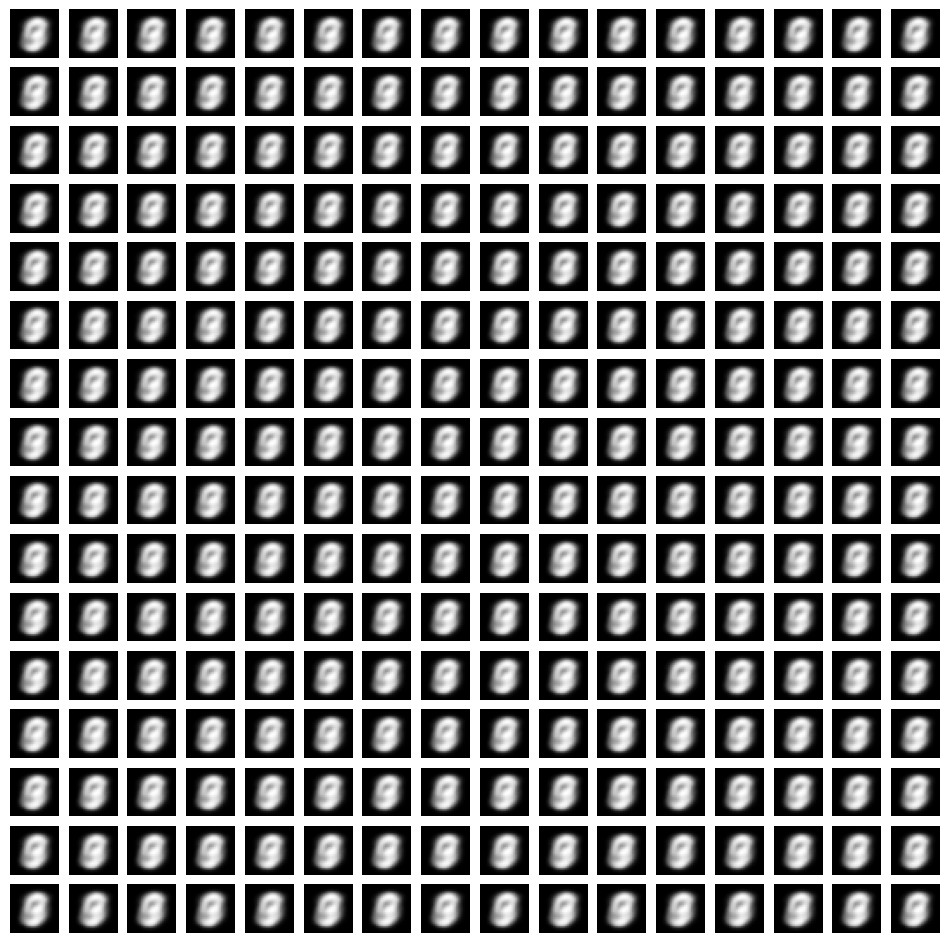

In [27]:
plt.figure(figsize=(12,12))
k=0
for i in grid_x:
  for j in grid_y:
    ax=plt.subplot(n,n,k+1)

    input=tf.constant([[i,j]])
    out=model.decoder.predict(input)[0][...,0]
    plt.imshow(out,cmap="Greys_r")
    plt.axis('off')
    k+=1

In [28]:
print(vae.layers[2].predict(tf.constant([[-1,1]]))[0][...,0].shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
(28, 28)


In [29]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
mnist_digits = np.expand_dims(x_train,-1).astype("float32") / 255

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


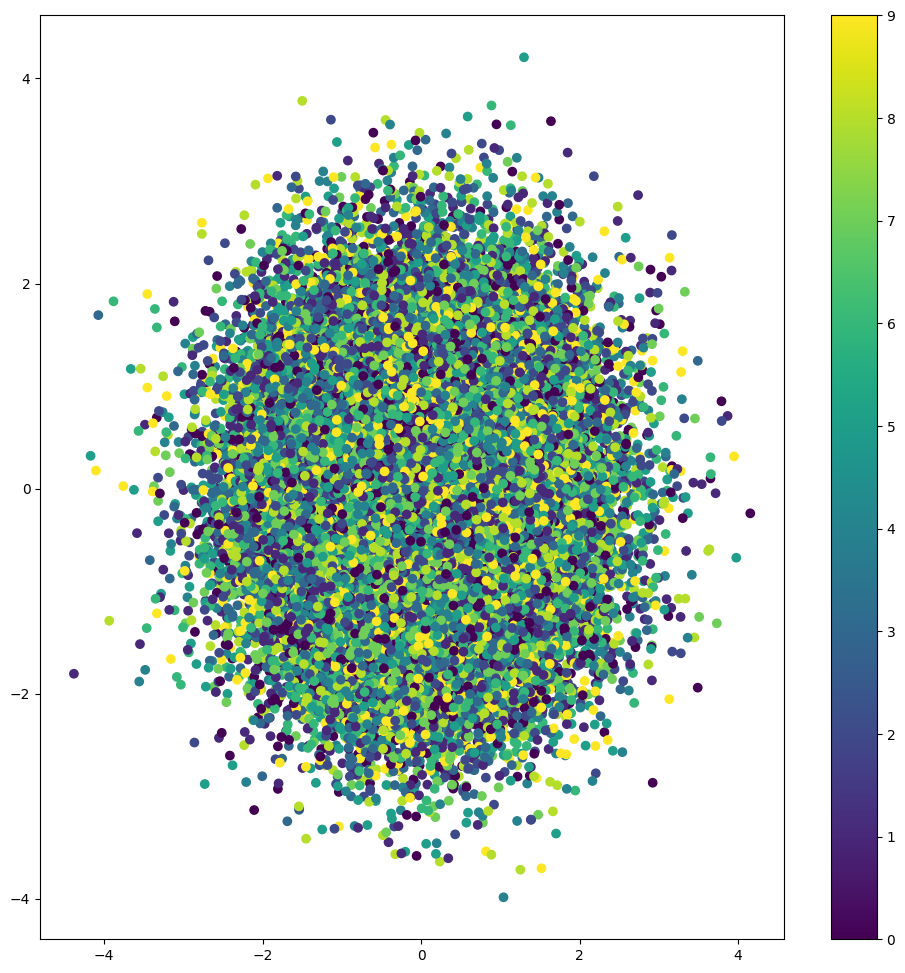

In [30]:
z,_,_=vae.layers[1].predict(x_train)
plt.figure(figsize=(12,12))
plt.scatter(z[:,0],z[:,1],c=y_train)
plt.colorbar()
plt.show()